# 実装例

▼ 本章で使用するデータセット

学習と検証用のデータセットはこちらから[bank_train.csv](https://drive.google.com/file/d/12ASy6rFUxeko2qWix2wKl-mYkCLJ--bK/view?usp=sharing)を使用してください。 

ここまでのデータの前処理や操作の実装を生かして、実際の問題設定において分類モデルを構築してみましょう。
今回の問題設定では、リクルーティングが成功（success）するか失敗（fail）するかを予測する二値分類モデルとなります。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

## ベースモデルの構築

### データの前処理

まずは必要な前処理のみを適用して、ベースラインとなる学習済みモデルを構築していきます。

In [ ]:
df = pd.read_csv('bank_train.csv')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,50.0,entrepreneur,married,secondary,no,1857,no,yes,-1.0,0,unknown,fail
1,37.0,technician,single,secondary,no,363,yes,no,-1.0,0,unknown,fail
2,35.0,blue-collar,married,primary,no,422,yes,no,-1.0,0,unknown,fail


In [ ]:
df.shape

(6416, 12)

まずは文字列で入っている教師データを、数値に置き換えます。

In [ ]:
# 教師データ確認
df['result'].value_counts()

fail       5683
success     733
Name: result, dtype: int64

In [ ]:
# 0,1 で補完
df['result'] = df['result'].map({'fail': 0, 'success': 1})

#### 欠損値処理

**欠損値の確認**

In [ ]:
df.isnull().sum()

age           90
job            3
marital       89
education      0
default       29
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

まずはベースラインのモデルとして欠損値は全て除去してしまいます。
その精度をベースに前処理や、ハイパーパラメータのチューニングを行なっていきます。

In [ ]:
#　全ての行を削除
df = df.dropna()
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
pdays        0
previous     0
poutcome     0
result       0
dtype: int64

#### カテゴリカル変数

カテゴリカル変数もひとまず、全てOne-Hot Encodingを適用します。

In [ ]:
# 全部 One-Hot Encoding
df = pd.get_dummies(df)
df.head(3)

,age,balance,pdays,previous,result,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,50.0,1857,-1.0,0,0,0,0,1,0,0,...,1,0,1,0,0,1,0,0,0,1
1,37.0,363,-1.0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1
2,35.0,422,-1.0,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,0,0,1


### モデルの構築

In [ ]:
t = df['result'].values
x = df.drop(['result'], axis=1).values

前処理が少なくて済む決定木でベースモデルを作成します。

In [ ]:
# モデルの宣言
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [ ]:
# モデルの学習
model.fit(x_train, t_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
# ベースモデルの検証
print(model.score(x_train, t_train))
print(model.score(x_val, t_val))

0.9992494370778083
0.8114419147694104


### Feature Importance の確認

<BarContainer object of 33 artists>

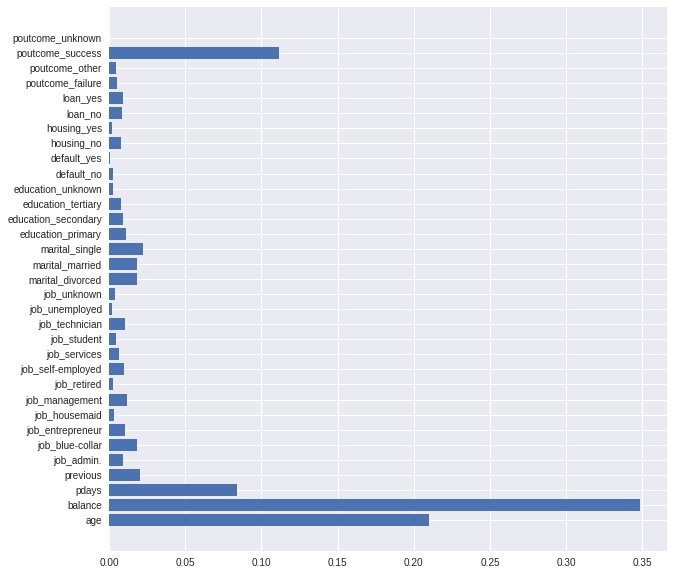

In [ ]:
# 特徴量重要度の確認
feature_importance = model.feature_importances_

# 目的変数削除し、説明変数のみとする
labels = df.drop('result', axis=1).columns.tolist()

plt.figure(figsize=(10,10))
plt.barh(labels, feature_importance)

ベースモデルの結果から、正解率の値に開きがあり、少し過学習気味のである事がわかります。
下記の3つのアプローチでこの結果を改善できるか試行錯誤してみます。

- データへのアプローチ（前処理）

- モデルへのアプローチ（ハイパーパラメータのチューニング）

- 手法へのアプローチ（手法の選択）

## データへのアプローチ

欠損値やカテゴリカル変数へのアプローチを工夫して、精度がどのように変化するのか確認します。  
実問題では、基本的には欠損値が含まれていたとしても、推論する必要があります。  
そのため、行方向への欠損値除去は用いずにサンプルを保持したまま学習する方が望ましいです。  
今回は全ての欠損値を補完していきます。

In [ ]:
# データフレームの読み込み
df2 = pd.read_csv('/content/bank_train.csv')
df2.head(3)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,50.0,entrepreneur,married,secondary,no,1857,no,yes,-1.0,0,unknown,fail
1,37.0,technician,single,secondary,no,363,yes,no,-1.0,0,unknown,fail
2,35.0,blue-collar,married,primary,no,422,yes,no,-1.0,0,unknown,fail


### 欠損値補完

In [ ]:
# 欠損値の確認
nullsum = df2.isnull().sum()
nullsum

age           90
job            3
marital       89
education      0
default       29
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

#### Job の欠損値補完

職業を表す、 `job` の欠損値補完を行います。
まずはデータを確認しましょう。

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


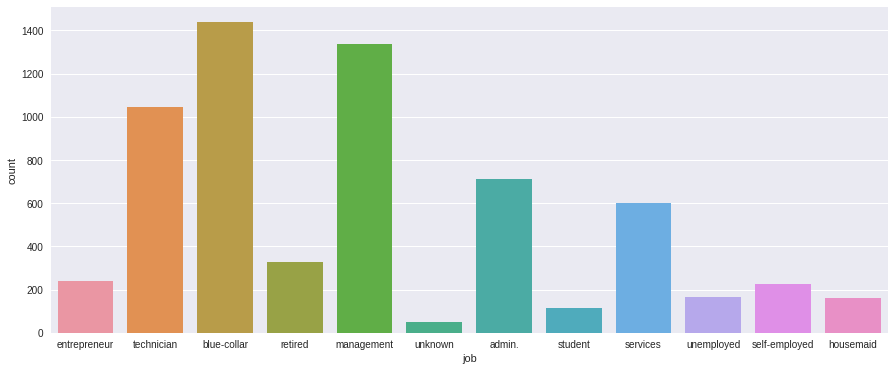

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(df2['job'])

データの中に `unknown` というものがあるので、そちらで補完しましょう。

In [ ]:
df2 = df2.fillna({'job':'unknown'})
df2.isnull().sum()

age           90
job            0
marital       89
education      0
default       29
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

#### Age の欠損値補完

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


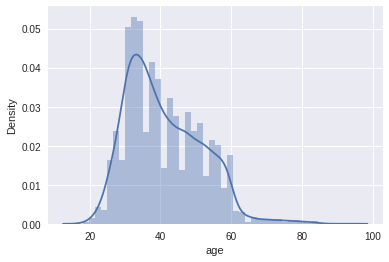

In [ ]:
sns.distplot(df2['age'].dropna())

データの総数からみて、欠損の値の数が多くないようなので、一度平均値で補完して問題ないか確認します。

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


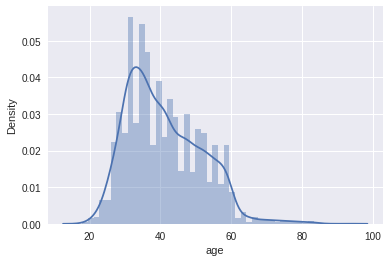

In [ ]:
# 平均値で補完
df2 = df2.fillna({'age':df['age'].mean()})
sns.distplot(df2['age'])

分布にも大きな乱れはなく、正規分布に少し近づいた形になりました。

In [ ]:
# 欠損値の確認
df2.isnull().sum()

age            0
job            0
marital       89
education      0
default       29
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

#### Marital の欠損値補完

In [ ]:
# 値の確認
df2['marital'].unique()

array(['married', 'single', 'divorced', nan], dtype=object)

`martial` が表しているのは、結婚、独身、離婚の3つのカテゴリーです。  
この指標に関しては年齢や職業が大きく関連しているように考えることができそうです。  
では、実験的に職業で考えてみましょう。

まずは `crosstab` （クロス集計表）を使用して数値の関係性を確認してみます。  
その前にどの職業で `NaN` なのか確認してみましょう。

In [ ]:
# maritalがNaNのjobのデータを抽出
marital_null = df2[df2['marital'].isnull()][['job', 'marital']]
marital_null.head(2)

,job,marital
66,blue-collar,NaN
69,blue-collar,NaN


In [ ]:
# jobの中でuniqueを確認
marital_null['job'].unique()

array(['blue-collar', 'student'], dtype=object)

blue-collaer か student のいずれかで補完する。

In [ ]:
# crosstabで関係性を確認
pd.crosstab(df2['marital'], df2['job'])

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
marital,,,,,,,,,,,,
divorced,111,112,36,27,145,52,17,80,0,112,20,6
married,358,960,175,112,769,255,139,333,8,591,100,39
single,241,300,31,20,421,19,69,187,86,340,48,8


`student` は `single` である可能性が高そうです。  
`blue-collar` は `married` で補完が妥当であるように感じます。

補完は今までの方法ではうまくいきません、条件文を適応する方法はいくつかありますが、  
`loc` 関数を使用して、特定のデータを切り出し補完する値を代入する方法がわかりやすいかと思います。

In [ ]:
# df.loc[条件文]で取得したいデータを指定　　> martial が null であり、job が student を抽出
df2.loc[(df2['marital'].isnull()) & (df2['job'] == 'student')]

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
516,31.0,student,NaN,tertiary,no,4951,no,no,-1.0,0,unknown,fail
547,26.0,student,NaN,secondary,no,1209,yes,no,-1.0,0,unknown,fail
555,24.0,student,NaN,secondary,no,597,yes,no,-1.0,0,unknown,success
606,23.0,student,NaN,tertiary,no,113,no,NaN,-1.0,0,unknown,success
1726,27.0,student,NaN,secondary,no,111,no,no,-1.0,0,unknown,success
2860,26.0,student,NaN,secondary,no,655,no,no,-1.0,0,unknown,success
3258,18.0,student,NaN,unknown,no,108,no,no,-1.0,0,unknown,success
3272,33.0,student,NaN,unknown,no,1170,no,no,-1.0,0,unknown,success
3291,23.0,student,NaN,secondary,no,480,no,no,182.0,1,failure,success
3321,22.0,student,NaN,unknown,no,3317,no,NaN,-1.0,0,unknown,fail


In [ ]:
# df.loc[条件文, 列名] = 値で値を代入
df2.loc[(df2['marital'].isnull()) & (df2['job'] == 'student'), 'marital'] = 'single' # student は single で補完
df2.loc[(df2['marital'].isnull()) & (df2['job'] == 'blue-collar'), 'marital'] = 'married' # mattial は married で補完

In [ ]:
df2.isnull().sum()

age            0
job            0
marital        0
education      0
default       29
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

#### Default の欠損値補完

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


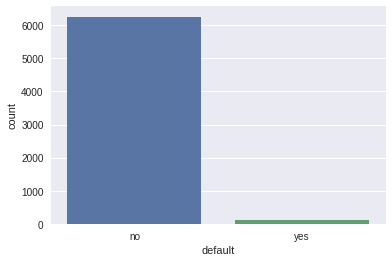

In [ ]:
sns.countplot(df2['default'])

データを確認してみると、かなり偏りがありそうです。 最頻値で補完を行います。

In [ ]:
# 最頻値の取得
df2['default'].mode()[0]

'no'

In [ ]:
# 欠損値の補完
df2['default'] = df2['default'].fillna(df2['default'].mode()[0])

In [ ]:
df2.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

#### Housing の欠損値補完

`Housing` が表すのは家のローンの有無です。  
こちらも年齢と職業が大きく関連していると考えられます。  

では、その仮説を元にどのように欠損値を補完できるか確認します。

In [ ]:
# Uniqueな値の数を確認
df2['housing'].value_counts()

yes    3499
no     2856
Name: housing, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


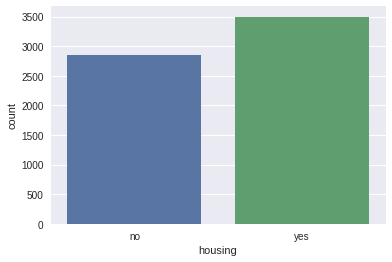

In [ ]:
sns.countplot(df2['housing'])

`housing` と `job` の関係性を確認します。

In [ ]:
# クロスタブ集計で数値を確認
pd.crosstab(df2['housing'], df2['job'])

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
housing,,,,,,,,,,,,
no,281,379,106,101,675,267,127,207,85,488,97,43
yes,421,1036,136,58,649,51,98,386,30,553,71,10


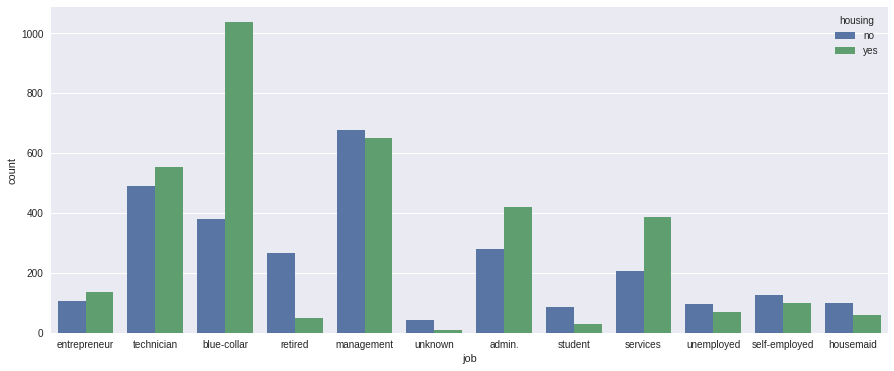

In [ ]:
# countplotでyesとnoに対応する数をカラムごとに算出
plt.figure(figsize=(15, 6))
sns.countplot(x='job', hue='housing', data=df2)

`housing` と `age` の関係性も確認します。

In [ ]:
pd.crosstab(df2['housing'], df2['age'])

age,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,...,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,86.0,93.0
housing,,,,,,,,,,,,,,,,,,,,,
no,2,2,5,7,11,7,10,31,55,49,...,5,6,4,3,3,2,6,1,1,1
yes,0,0,0,4,7,22,26,36,53,69,...,0,0,0,0,0,0,0,0,0,0


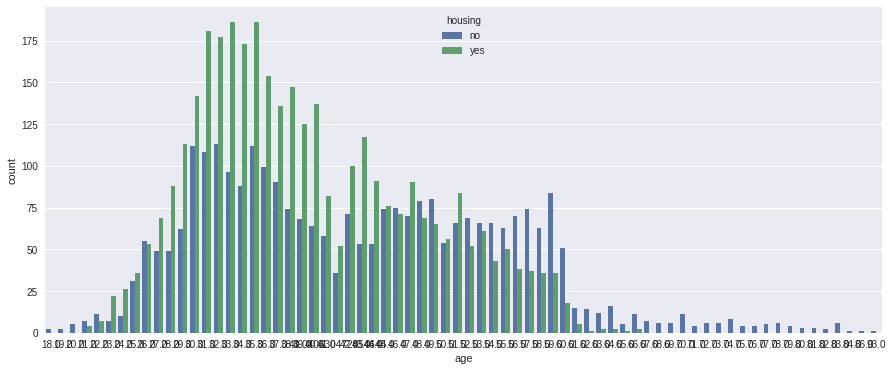

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(x='age', hue='housing', data=df2)

感覚的にどのように埋めればいいのかは確認することができました。  
実際にどこを補完する必要があるのかも確認しておき、アプローチを考えます。

In [ ]:
housing_null = df2[df2['housing'].isnull()][['housing', 'job', 'age']]
housing_null.head(2)

,housing,job,age
23,NaN,management,51.0
61,NaN,admin.,52.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


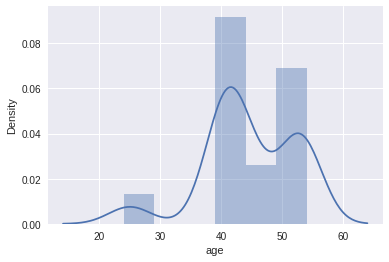

In [ ]:
sns.distplot(housing_null['age'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


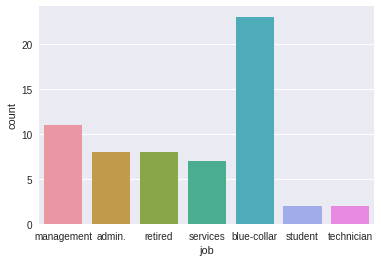

In [ ]:
sns.countplot('job', data=housing_null)

上記の可視化した情報から、感覚的に補完を行う値を決めます。

- `job` が `student` もしくは `retired` の場合は、 `no`

- その他の値は `yes` で補完（職業の内容と年齢の `housing` のデータをみても `yes` の数の方が多そうな為）

データフレームの条件抽出は `.loc` 関数を使用します。

In [ ]:
df2.loc[(df2['housing'].isnull()) & ((df2['job'] == 'student') | (df2['job'] == 'retired'))]

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
167,51.0,retired,married,secondary,no,0,NaN,no,-1.0,0,NaN,fail
636,51.0,retired,married,primary,no,229,NaN,no,-1.0,0,unknown,fail
2037,24.0,student,single,unknown,no,0,NaN,no,-1.0,0,unknown,fail
4094,54.0,retired,married,secondary,no,1614,NaN,no,-1.0,0,unknown,fail
4884,54.0,retired,divorced,tertiary,no,349,NaN,no,-1.0,0,unknown,fail
4903,51.0,retired,married,primary,no,34,NaN,no,-1.0,0,unknown,fail
5382,54.0,retired,divorced,secondary,no,1483,NaN,yes,-1.0,0,unknown,fail
5717,54.0,retired,married,secondary,no,1154,NaN,no,-1.0,0,unknown,fail
5807,24.0,student,single,secondary,no,486,NaN,no,270.0,2,other,fail
6032,54.0,retired,married,secondary,no,529,NaN,no,-1.0,0,unknown,fail


In [ ]:
# jobがstudent or retiredの場合、noで補完
df2.loc[(df2['housing'].isnull()) & ((df2['job'] == 'student') | (df2['job'] == 'retired')), 'housing'] = 'no'

In [ ]:
# その他の値をyesで補完
df2 = df2.fillna({'housing':'yes'})

In [ ]:
df2.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

#### PDays の欠損値補完

`pdays` が表しているのは前回のキャンペーンで通話してからの経過日数（単位：日）です。  
まずは分布を確認してみます。

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


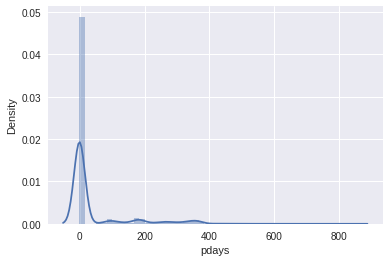

In [ ]:
# 分布を確認 -> 偏りがあり、最小値で補完してもよさそう
sns.distplot(df2['pdays'].dropna())

In [ ]:
# 最小値の確認
df2['pdays'].describe()

count    6380.000000
mean       39.616458
std        97.745220
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max       838.000000
Name: pdays, dtype: float64

In [ ]:
# 最小値で補完
df2 = df2.fillna({'pdays':df2['pdays'].min()})

In [ ]:
df2.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan         217
pdays          0
previous       0
poutcome     250
result         0
dtype: int64

#### Poutcome の欠損値補完

`poutcome` は前回キャンペーンの成約状況を表す変数です。  
中身を確認し、アプローチを確認します。

In [ ]:
df2['poutcome'].value_counts()

unknown    4998
failure     695
other       253
success     220
Name: poutcome, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


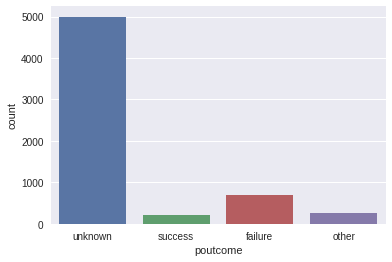

In [ ]:
sns.countplot(df2['poutcome'])

変数の中に unknown があり、かつ数も最も多いのでこちらで補完します。

In [ ]:
df2 = df2.fillna({'poutcome':'unknown'})

In [ ]:
df2.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan         217
pdays          0
previous       0
poutcome       0
result         0
dtype: int64

#### Loan の欠損値補完

中身を確認し、アプローチを方法を考えます。

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


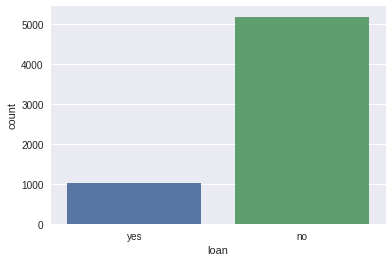

In [ ]:
sns.countplot(df2['loan'])

`loan` の中身は `yes` か `no` のどちらかの文字列が入っています。  
比率としては圧倒的に `no` が多いようなので、 `no` で補完します。

In [ ]:
df2 = df2.fillna({'loan':'no'})
df2.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
pdays        0
previous     0
poutcome     0
result       0
dtype: int64

欠損値の補完が完了しました。  
ここで精度が出るか確認してみましょう。

### 精度の検証（1）

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df2['result'] = le.fit_transform(df2['result'])
df2_dum = pd.get_dummies(df2)
df2_dum.shape

(6416, 34)

In [ ]:
t = df2_dum['result'].values
x = df2_dum.drop(['result'], axis=1).values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=1)

In [ ]:
# モデルの宣言
model = DecisionTreeClassifier(random_state=0)

In [ ]:
# モデルの学習
model.fit(x_train, t_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
# モデルの検証
print(model.score(x_train, t_train))
print(model.score(x_val, t_val))

0.9991093297706524
0.828051948051948


わずかに精度が上がりました。  
全体のサンプル数に対して、欠損値の数が多くなかった為影響が大きくなかったことが推測されます。  
続いてはEncodingの方法について確認します。

### カテゴリカル変数へのアプローチ

#### Label Encoding

まずは2値のものに関してはLabel Encodingを適用させます。

In [ ]:
df3 = df2.copy()
df_obj = df3.select_dtypes(include='object')
df_obj.head(2)

,job,marital,education,default,housing,loan,poutcome
0,entrepreneur,married,secondary,no,no,yes,unknown
1,technician,single,secondary,no,yes,no,unknown


In [ ]:
# カテゴリカル変数のそれぞれのUnique数を確認
str_uni = df_obj.nunique() # Uniqueの数を変数に格納
str_uni

job          12
marital       3
education     4
default       2
housing       2
loan          2
poutcome      4
dtype: int64

In [ ]:
col_le = str_uni[str_uni == 2].index
col_le

Index(['default', 'housing', 'loan'], dtype='object')

In [ ]:
df3[col_le[0]].unique()

array(['no', 'yes'], dtype=object)

文字列が2値の列名が取得できたので、Label Encodingを適用します。

In [ ]:
for col in col_le:
    le = LabelEncoder()
    df3[col] = le.fit_transform(df3[col])

In [ ]:
df3.head(10)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,50.0,entrepreneur,married,secondary,0,1857,0,1,-1.0,0,unknown,0
1,37.0,technician,single,secondary,0,363,1,0,-1.0,0,unknown,0
2,35.0,blue-collar,married,primary,0,422,1,0,-1.0,0,unknown,0
3,55.0,retired,married,secondary,0,119,0,1,-1.0,0,unknown,0
4,40.0,blue-collar,single,secondary,0,1066,1,0,-1.0,0,unknown,0
5,59.0,retired,married,secondary,0,1080,0,0,-1.0,0,unknown,0
6,40.0,technician,married,secondary,0,3056,0,0,-1.0,0,unknown,0
7,43.0,management,single,tertiary,0,-2,0,1,-1.0,0,unknown,0
8,59.0,unknown,married,primary,0,282,0,0,-1.0,0,unknown,0
9,25.0,entrepreneur,single,tertiary,1,6,1,1,-1.0,0,unknown,0


### 精度の検証(2)

In [ ]:
df3.head(3)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,50.0,entrepreneur,married,secondary,0,1857,0,1,-1.0,0,unknown,0
1,37.0,technician,single,secondary,0,363,1,0,-1.0,0,unknown,0
2,35.0,blue-collar,married,primary,0,422,1,0,-1.0,0,unknown,0


In [ ]:
df3_dum = pd.get_dummies(df3)
df3_dum.shape

(6416, 31)

In [ ]:
t = df3_dum['result'].values
x = df3_dum.drop(['result'], axis=1).values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=1)

In [ ]:
# モデルの宣言
model = DecisionTreeClassifier(random_state=0)

# モデルの学習
model.fit(x_train, t_train)

# モデルの検証
print(model.score(x_train, t_train))
print(model.score(x_val, t_val))

0.9991093297706524
0.8296103896103896


少し精度に変動がありましたが、大きくは変わりませんでした。  
Encodingの方法はアルゴリズムによって、変更すると精度にも影響が出るため、検証する上で複数のEncodingを行うことをオススメします。  

`df3` のデータを用いてハイパーパラメータの調整を行います。

## モデルへのアプローチ

ハイパーパラメータのチューニングを行なっていきます。  
今回はグリッドサーチを用います。

In [ ]:
df3_dum.head(3)

,age,default,balance,housing,loan,pdays,previous,result,job_admin.,job_blue-collar,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,50.0,0,1857,0,1,-1.0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,37.0,0,363,1,0,-1.0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
2,35.0,0,422,1,0,-1.0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1


In [ ]:
t = df3_dum['result'].values
x = df3_dum.drop(['result'], axis=1).values

K-分割交差検証を用いて精度を計測するため、データはこのまま使用します。

### Grid Search の適用

In [ ]:
from sklearn.model_selection import GridSearchCV

estimator = DecisionTreeClassifier(random_state=0)

# チューニングを行うハイパーパラメータとその範囲の指定
max_depth = np.linspace(2, 15, 10, dtype=int)
min_samples_split = np.linspace(2, 20, 3, dtype=int)

param_grid = [
    {'max_depth': max_depth, 'min_samples_split': min_samples_split}
]

cv = 5

print('max_depth:{}, min_samples_leaf:{}, cv:{}'.format(max_depth, min_samples_split, cv))

max_depth:[ 2  3  4  6  7  9 10 12 13 15], min_samples_leaf:[ 2 11 20], cv:5


In [ ]:
# モデルの宣言
tuned_model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, return_train_score=False)

# モデルの学習
tuned_model.fit(x, t)

# 精度の確認
pd.DataFrame(tuned_model.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
mean_fit_time,0.010106,0.010713,0.020085,0.028801,0.045261,0.035878,0.015709,0.021598,0.028921,0.053411,...,0.076656,0.092164,0.057605,0.075254,0.070575,0.08549,0.081503,0.088049,0.097397,0.082312
std_fit_time,0.001362,0.003967,0.004629,0.004817,0.012098,0.007369,0.002889,0.012366,0.006736,0.007179,...,0.023618,0.012283,0.02178,0.012677,0.008834,0.023727,0.021405,0.011178,0.019122,0.015422
mean_score_time,0.006602,0.000751,0.001572,0.001519,0.004177,0.005508,0.000803,0.000834,0.002345,0.002348,...,0.002191,0.010206,0.004391,0.005832,0.004736,0.001897,0.003377,0.007311,0.003971,0.002248
std_score_time,0.011625,0.000036,0.001467,0.001341,0.00469,0.004911,0.000035,0.000072,0.002777,0.002697,...,0.002047,0.006694,0.004131,0.004935,0.003238,0.001378,0.004445,0.012061,0.004586,0.002053
param_max_depth,2,2,2,3,3,3,4,4,4,6,...,10,12,12,12,13,13,13,15,15,15
param_min_samples_split,2,11,20,2,11,20,2,11,20,2,...,20,2,11,20,2,11,20,2,11,20
params,"{'max_depth': 2, 'min_samples_split': 2}","{'max_depth': 2, 'min_samples_split': 11}","{'max_depth': 2, 'min_samples_split': 20}","{'max_depth': 3, 'min_samples_split': 2}","{'max_depth': 3, 'min_samples_split': 11}","{'max_depth': 3, 'min_samples_split': 20}","{'max_depth': 4, 'min_samples_split': 2}","{'max_depth': 4, 'min_samples_split': 11}","{'max_depth': 4, 'min_samples_split': 20}","{'max_depth': 6, 'min_samples_split': 2}",...,"{'max_depth': 10, 'min_samples_split': 20}","{'max_depth': 12, 'min_samples_split': 2}","{'max_depth': 12, 'min_samples_split': 11}","{'max_depth': 12, 'min_samples_split': 20}","{'max_depth': 13, 'min_samples_split': 2}","{'max_depth': 13, 'min_samples_split': 11}","{'max_depth': 13, 'min_samples_split': 20}","{'max_depth': 15, 'min_samples_split': 2}","{'max_depth': 15, 'min_samples_split': 11}","{'max_depth': 15, 'min_samples_split': 20}"
split0_test_score,0.899533,0.899533,0.899533,0.899533,0.899533,0.899533,0.898754,0.898754,0.898754,0.898754,...,0.894081,0.884735,0.890187,0.89486,0.888629,0.888629,0.895639,0.878505,0.880841,0.890187
split1_test_score,0.899454,0.899454,0.899454,0.898675,0.898675,0.898675,0.898675,0.898675,0.898675,0.893219,...,0.893219,0.886204,0.89244,0.890881,0.883087,0.888542,0.89166,0.872954,0.885425,0.889322
split2_test_score,0.893998,0.893998,0.893998,0.894778,0.894778,0.894778,0.890881,0.890881,0.890881,0.886204,...,0.882307,0.877631,0.881528,0.883866,0.879189,0.880748,0.886204,0.870616,0.872954,0.879969


In [ ]:
# 最適なモデルの確認
print(tuned_model.best_params_, tuned_model.best_score_)

{'max_depth': 3, 'min_samples_split': 2} 0.8965082567871738


先ほどとデータの分割方法が異なるため、厳密には同じ前提ではないですが、精度に向上が見られました。  
範囲を大きく確認したので、得られた結果を元にさらにグリッドサーチを適応します。  
1度目の結果を max_depth=2 、 min_samples_split=2 が最も良い結果でした。このあたりをもう一度確認して見ます。

In [ ]:
# モデルの定義
estimator = DecisionTreeClassifier(random_state=0)

# チューニングを行うハイパーパラメータとその範囲の指定
max_depth = np.linspace(2, 10, 3, dtype=int)
min_samples_split = np.linspace(2, 5, 3, dtype=int)

param_grid = [
    {'max_depth': max_depth,
    'min_samples_split': min_samples_split
    }
]

cv = 5

print('max_depth:{}, min_samples_leaf:{}, cv:{}'.format(max_depth, min_samples_split, cv))

max_depth:[ 2  6 10], min_samples_leaf:[2 3 5], cv:5


In [ ]:
# モデルの宣言
tuned_model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, return_train_score=False)

# モデルの学習
tuned_model.fit(x_train, t_train)

# 精度の確認
pd.DataFrame(tuned_model.cv_results_).T

,0,1,2,3,4,5,6,7,8
mean_fit_time,0.006421,0.00818,0.005482,0.019164,0.014957,0.023851,0.047985,0.039717,0.040567
std_fit_time,0.001803,0.003101,0.000172,0.005768,0.004468,0.009693,0.009068,0.009199,0.009996
mean_score_time,0.002111,0.000681,0.000731,0.001202,0.000754,0.001951,0.000936,0.000946,0.003553
std_score_time,0.002727,0.000023,0.000085,0.000816,0.000117,0.002327,0.00005,0.000069,0.003255
param_max_depth,2,2,2,6,6,6,10,10,10
param_min_samples_split,2,3,5,2,3,5,2,3,5
params,"{'max_depth': 2, 'min_samples_split': 2}","{'max_depth': 2, 'min_samples_split': 3}","{'max_depth': 2, 'min_samples_split': 5}","{'max_depth': 6, 'min_samples_split': 2}","{'max_depth': 6, 'min_samples_split': 3}","{'max_depth': 6, 'min_samples_split': 5}","{'max_depth': 10, 'min_samples_split': 2}","{'max_depth': 10, 'min_samples_split': 3}","{'max_depth': 10, 'min_samples_split': 5}"
split0_test_score,0.884316,0.884316,0.884316,0.887653,0.888765,0.887653,0.889878,0.888765,0.887653
split1_test_score,0.894209,0.894209,0.894209,0.89755,0.89755,0.896437,0.885301,0.885301,0.887528
split2_test_score,0.905345,0.905345,0.905345,0.905345,0.905345,0.906459,0.894209,0.893096,0.893096


In [ ]:
# 最適なモデルの確認
print(tuned_model.best_params_, tuned_model.best_score_)

{'max_depth': 6, 'min_samples_split': 3} 0.896906733787356


少しだけ精度が向上しました。 Feature Importance を確認してどの入力変数が聞いているのか見てみます。

<BarContainer object of 30 artists>

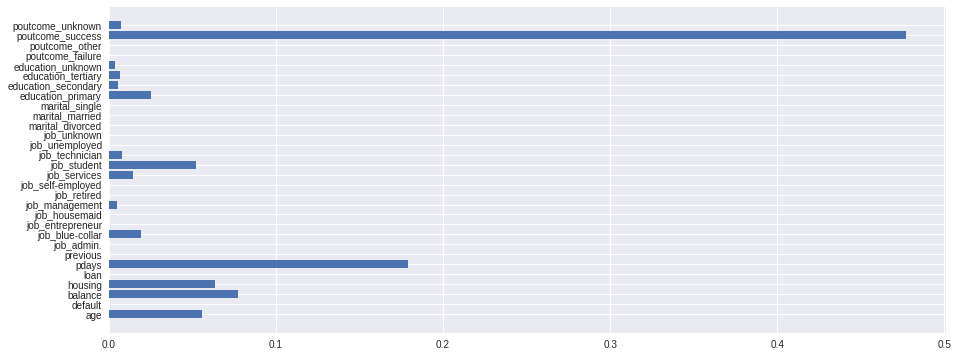

In [ ]:
feature_importance = tuned_model.best_estimator_.feature_importances_

labels = df3_dum.drop('result', axis=1).columns.tolist()

plt.figure(figsize=(15, 6))
plt.barh(labels, feature_importance)

いくつかの特徴量が強い効果がある事が確認できます。  
この結果から特徴量エンジニアリングを行い、新たな特徴量の作成など行う事ができそうです。

## 手法へのアプローチ

先ほどまでは決定木のみで精度がどのようになるのか確認してきました。
他の手法でもどのように変化が出るのか確認してみます。
試行する手法は下記の 2 つを使用します。

- サポートベクターマシン（SVM）
- XGBoost

### サポートベクターマシン

データを標準化して、学習を行います。

In [ ]:
# モデルの定義
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 標準化の適用
x_transform = scaler.fit_transform(x)

グリッドサーチは行わず、K-分割交差検証を使用して学習を行います。

In [ ]:
# モデルの定義
from sklearn.svm import SVC
model = SVC(random_state=0)

# モデルの学習&検証
from sklearn.model_selection import cross_val_score
cross_val_score(model, x_transform, t, cv=5).mean()

0.8971316739631364

先ほどの決定木よりいい精度が出ました。  
チューニングを行う前に XGBoost の結果も確認しておきます。

### XGBoost

In [ ]:
# モデルの宣言
from xgboost import XGBClassifier
model = XGBClassifier(random_state=0)

# モデルの学習&検証
cross_val_score(model, x_transform, t, cv=5).mean()

0.8946377624483116

こちらもいい精度が出ている事が確認できました。  
まだチューニングを行なっていないので、まだ精度向上の余地がありそうです。  

### ハイパーパラメータのチューニング：XGBoost

In [ ]:
estimator = XGBClassifier(random_state=0)

# チューニングを行うハイパーパラメータとその範囲の指定
# linspace(start, stop, num) で start から stop　の間の num（要素数）分の間隔を計算
max_depth = np.linspace(2, 15, 3, dtype=int)
n_estimators = np.linspace(80, 200, 3, dtype=int)
param_grid = [
    {'max_depth' : max_depth,  'n_estimators' : n_estimators}
]
cv = 5
print('max_depth:{}, n_estimators:{}, cv:{}'.format(max_depth, n_estimators, cv))

max_depth:[ 2  8 15], n_estimators:[ 80 140 200], cv:5


In [ ]:
# モデルの定義
tuned_model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, return_train_score=False, n_jobs=-1)

# モデルの学習
tuned_model.fit(x_transform, t)

# 最適なモデルの確認
print(tuned_model.best_params_, tuned_model.best_score_)

{'max_depth': 8, 'n_estimators': 80} 0.8947940113101354


### ハイパーパラメータチューニング：SVM

ハイパーパラメータの探索する範囲が広いので、ベイズ最適化を使用します。  
試行する回数はある一定数必要となるので、学習には時間がかかります。

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def objective(trial, x, t, cv):
  C = trial.suggest_uniform('C', 0.1, 100)
  gamma = trial.suggest_uniform('gamma', 1, 200)
  estimator = SVC(
      C = C,
      gamma = gamma
  )
  accuracy = cross_val_score(estimator, x, t, cv=cv).mean()
  return 1 - accuracy

今回は実数値の間で探索範囲を設定するため `suggest_uniform` を使用してしています。

In [ ]:
cv = 5
n_trials = 30

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(0))
study.optimize(lambda trial: objective(trial, x_transform, t, cv), n_trials=n_trials)
print(study.best_trial)

[I 2022-04-13 06:53:24,118] A new study created in memory with name: no-name-c8e4d259-8b51-4860-97fe-ee64c6d3313c
[I 2022-04-13 06:54:08,923] Trial 0 finished with value: 0.12889741964777846 and parameters: {'C': 54.92646904233975, 'gamma': 143.3226839081115}. Best is trial 0 with value: 0.12889741964777846.
[I 2022-04-13 06:54:26,021] Trial 1 finished with value: 0.1304561446959157 and parameters: {'C': 60.31606126955723, 'gamma': 109.43175341638248}. Best is trial 0 with value: 0.12889741964777846.
[I 2022-04-13 06:54:43,103] Trial 2 finished with value: 0.12905318288765388 and parameters: {'C': 42.423114453956586, 'gamma': 129.53292850026457}. Best is trial 0 with value: 0.12889741964777846.
[I 2022-04-13 06:54:56,161] Trial 3 finished with value: 0.1279621117756038 and parameters: {'C': 43.814962405142985, 'gamma': 178.46282715563387}. Best is trial 3 with value: 0.1279621117756038.
[I 2022-04-13 06:55:13,096] Trial 4 finished with value: 0.1365349174321283 and parameters: {'C': 96

FrozenTrial(number=17, values=[0.12422148731434057], datetime_start=datetime.datetime(2022, 4, 13, 6, 58, 15, 889780), datetime_complete=datetime.datetime(2022, 4, 13, 6, 58, 32, 352252), params={'C': 1.9771010635918789, 'gamma': 123.90946391809953}, distributions={'C': UniformDistribution(high=100.0, low=0.1), 'gamma': UniformDistribution(high=200.0, low=1.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=17, state=TrialState.COMPLETE, value=None)


Cは値が小さくなるほど、精度向上に関連がありそうです。  
gammaに関してはどのあたりの値がいいのかはまだわからないです。  
Cの値でグリッドサーチを実行し、チューニングしてみます。

In [ ]:
# チューニングするモデルの宣言
estimator = SVC(random_state=0)

# チューニングを行うハイパーパラメータとその範囲の指定
C = np.linspace(0.1, 1, 10, dtype=float)
param_grid = [
    {'C' : C}
]
cv = 5
print('C:{}, cv:{}'.format(C, cv))

C:[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ], cv:5


In [ ]:
# モデルの定義
tuned_model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, return_train_score=False, n_jobs=-1)

# モデルの学習
tuned_model.fit(x_transform, t)

# 最適なモデルの確認
print(tuned_model.best_params_, tuned_model.best_score_)

{'C': 0.5} 0.8980669818353111


In [ ]:
# 最適なモデルの引き継ぎ
best_model = tuned_model.best_estimator_
best_model

SVC(C=0.5, random_state=0)

少しですが、精度向上ができました。  
このようにチューニングを繰り返すことによって、精度向上を行う事ができます。  
しかし、あくまでモデルの作成意義は新たなデータに対して、正しく推論できる事です。  

モデルのチューニングも重要ですが、過学習が起きていないかも注意しましょう。

## テストデータで評価

テストデータに対して、どれくらいの精度になっていることを確認しましょう。

In [ ]:
df_test = pd.read_csv('/content/bank_test (1).csv')
df_test.head(2)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,55.0,self-employed,married,tertiary,no,1810,yes,no,-1.0,0,unknown,fail
1,54.0,management,married,tertiary,no,364,yes,no,-1.0,0,unknown,fail


In [ ]:
df_test.isnull().sum()

age           35
job            8
marital       45
education      0
default       62
balance        0
housing      114
loan          24
pdays         79
previous       0
poutcome     152
result         0
dtype: int64

推論を行う際には訓練データに適用した前処理と同じ前処理を適用する必要があります。  
学習時から下記のように関数にまとめておくと、いいでしょう。  
データフレームを関数に渡すと、xとtが取得できる関数を作成しました。

In [ ]:
def prepare_data(df):

    #  Jobの欠損値補完
    df = df.fillna({'job':'unknown'})

    # Ageの欠損値補完
    df = df.fillna({'age':df['age'].mean()})

    #  Maritalの欠損値補完
    marital_null = df[df['marital'].isnull()][['job', 'marital']]
    df.loc[(df['marital'].isnull()) & (df['job'] == 'student'), 'marital'] = 'single'
    df.loc[(df['marital'].isnull()) & (df['job'] == 'blue-collar'), 'marital'] = 'married'

    # Defaultの欠損値補完
    df['default'] = df['default'].fillna(df['default'].mode()[0])

    # Hosingの欠損値補完
    df.loc[(df['housing'].isnull()) & ((df['job'] == 'student') | (df['job'] == 'retired')), 'housing'] = 'no'
    df = df.fillna({'housing':'yes'})

    # Pdaysの欠損値補完
    df = df.fillna({'pdays':df['pdays'].min()})

    # Poutcomeの欠損値補完
    df = df.fillna({'poutcome':'unknown'})

    #  Loanの欠損値補完
    df = df.fillna({'loan':'no'})

    # Label Encoding
    str_uni = df.select_dtypes(include='object').nunique()
    col_le = str_uni[str_uni == 2].index
    for col in col_le:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    # One-Hot Encoding
    df = pd.get_dummies(df)

    # x, tの切り分け
    t = df['result'].values
    x = df.drop(['result'], axis=1).values

    # 標準化
    x = scaler.transform(x)

    return x, t

In [ ]:
# 関数の実行
x_test, t_test = prepare_data(df_test)

x_test.shape, t_test.shape

((15000, 30), (15000,))

In [ ]:
# 欠損値の確認
np.any(np.isnan(x_test))

False

In [ ]:
# ラベルが0と1であることを確認
np.unique(t_test)

array([0, 1])

### Accuracy の確認

In [ ]:
best_model.score(x_test, t_test)

0.8918

精度を確認する事ができました。  


まだこの問題に対して、精度をあげる方法としては、特徴量エンジニアリングなどの前処理、その他の手法の試行など様々な方法が考えられます。  
この講義が終わった後も、色々試行錯誤して見てください。  

これで演習課題は終了です。お疲れ様でした。